In [1]:
import pandas as pd
import numpy as np

import pingouin as pg
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from tqdm.auto import tqdm

%matplotlib inline

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Задача 1
Написать функцию на языке Python, которая будет принимать в себя датасет и считать **retention** игроков (по дням от даты регистрации игрока).

### Загрузка исходных данных для первой задачи

In [2]:
reg_df  = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/BQ1-qD8o67JjHg', sep=';')
auth_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/c_50rJhKWZ_pCQ', sep=';')

### Описание данных в таблице reg_df

В таблице представлены данные о времени регистрации.

- **reg_ts** - timestamp с временем регистрации
- **uid** - столбец с **user id** пользователей

In [3]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [4]:
reg_df.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


### Описание данных в таблице auth_df

В таблице представлены данные о времени входа пользователей в игру.

- **auth_ts** - timestamp с временем захода пользователей в игру
- **uid** - столбец с **user id** пользователей

In [5]:
auth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [6]:
auth_df.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


### Привидение типов
Так как в данных даты представлены в формате **timestamp**, то рационально перевести тип данных в **datetime** и оставить только даты, исключив время совершаемого действия, чтобы было проще воспринимать информацию и строить когортный анализ.

In [7]:
reg_df['reg_ts'] = pd.to_datetime(reg_df.reg_ts, unit='s')
reg_df['reg_ts'] = reg_df.reg_ts.apply(lambda x: x.date())

In [8]:
auth_df['auth_ts'] = pd.to_datetime(auth_df.auth_ts, unit='s')
auth_df['auth_ts'] = auth_df.auth_ts.apply(lambda x: x.date())

### Объединение датафреймов
Для выполнения исходной задачи необходимо объединить имеющиеся датафреймы. Сделаем это посредством **left join** таблицы с датами регистрации к таблице с данными о входе в приложение по колонке **uid**.

In [9]:
retention_data = auth_df.merge(reg_df, how='left', on='uid')

### Требуемая функция

In [10]:
def cohort_analysis(data, start_cohort, end_cohort, start_period, end_period):
    
    """
       Функция реализует метод построения когорт для изучения retention пользователей приложения по дням.
       
       Параметры
       ---------
       data: pandas DataFrame
           Датасет
       
       start_cohort: string
           Строка, содержащая начальную для анализа когорту (дату формата гггг-мм-дд)
       
       end_cohort:   string
           Строка, содержащая конечнную для анализа когорту (дату формата гггг-мм-дд)
           
       start_period: int
           Число, содержащее в себе начальное для анализа количество дней, прошедших со дня регистрации
       
       end_period:   int
           Число, содержащее в себе корнечное для анализа количество дней, прошедших со дня регистрации    
    """
    
    # Привидем типы данных для последующей фильтрации по датам
    start_cohort = pd.to_datetime(start_cohort)
    end_cohort = pd.to_datetime(end_cohort)
    
    # Группируем данные по когортам и датам авторизации
    # Считаем количество пользователей, совершивших авторизацию, в каждом периоде по каждой когорте
    cohort_df = retention_data \
        .groupby(['reg_ts', 'auth_ts'], as_index=False) \
        .agg(n_users=('uid', 'nunique')) \
        .rename(columns={'reg_ts': 'cohort'})
    
    # Создадим колонку, в которой найдем разницу в днях между датой регистрации и датой авторизации
    cohort_df['period_num'] = (cohort_df.auth_ts - cohort_df.cohort).dt.days
    
    # Преобразуем данные в сводную таблицу
    cohort_pivot = cohort_df.pivot_table(index   = 'cohort',        # Строки - когорты
                                         columns = 'period_num',    # Колонки - периоды (разница между когортой)
                                         values  = 'n_users')       # Значения - количество пользователей, вошедших в игру
    
    # Создаем pdSeries с количеством зарегистрировавшихся пользователей, в когорте
    cohort_size = cohort_pivot.iloc[:,0]
    
    # Рассчитываем retention: долю атворизовавшихся пользователей в периоде относительно количества пользователей в когорте
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    
    # Фильтруем данные по интересующим нас когортам и периодам
    retention_matrix = retention_matrix.loc[start_cohort:end_cohort, start_period:end_period]
    
    # Наводим марафет
    cohort_style = (retention_matrix
            .style
            .set_caption('User retention by cohort')  # Добавляем подпись
            .background_gradient(cmap='summer')       # Раскрашиваем ячейки по столбцам
            .highlight_null('white')                  # Делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))             # Числа форматируем как проценты, NaN заменяем на пустоту
    
    return cohort_style

### Результат работы функции
Построим когортный анализ для когорт с **2020-09-10** по **2020-09-23** и в периоде с **дня регистрации** по **13** день пользования приложением.

In [11]:
cohort_analysis(retention_data, '2020-09-10', '2020-09-23', 0, 13)

period_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2020-09-10,100.00%,2.05%,4.29%,4.79%,4.23%,6.77%,6.28%,7.09%,4.85%,4.54%,5.66%,4.72%,5.22%,3.60%
2020-09-11,100.00%,1.30%,4.03%,4.53%,5.65%,5.71%,6.70%,6.33%,4.40%,4.65%,5.40%,5.33%,3.29%,
2020-09-12,100.00%,1.92%,3.84%,4.71%,4.65%,6.07%,6.57%,5.76%,5.27%,5.14%,5.70%,2.54%,,
2020-09-13,100.00%,1.98%,4.08%,4.26%,5.13%,6.55%,6.49%,4.94%,4.70%,4.94%,3.58%,,,
2020-09-14,100.00%,2.22%,3.83%,4.51%,5.31%,6.49%,6.98%,6.30%,4.45%,2.90%,,,,
2020-09-15,100.00%,2.22%,4.07%,4.56%,6.04%,5.61%,6.90%,5.67%,2.46%,,,,,
2020-09-16,100.00%,1.91%,4.25%,4.62%,4.68%,6.77%,6.95%,3.38%,,,,,,
2020-09-17,100.00%,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%,,,,,,,
2020-09-18,100.00%,1.90%,4.54%,4.23%,5.21%,3.74%,,,,,,,,


# Задача 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Ответить на вопросы:

- Какой набор предложений можно считать лучшим?
- Какие метрики стоит проанализировать для принятия правильного решения и как?

In [12]:
exp_data = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep=';')

In [13]:
exp_data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [14]:
exp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Пропущенных значений в данных нет. Типы данных корректны.

In [15]:
# Проверка количества уникальных пользователей в исходных данных
exp_data.user_id.nunique()

404770

Все пользователи являются уникальными

In [16]:
# Разбивка данных по группам
exp_a = exp_data.query("testgroup == 'a'")
exp_b = exp_data.query("testgroup == 'b'")

# Разбивка данных по группам, включая только платящих пользователей
exp_a_payment = exp_data.query("testgroup == 'a' and revenue != 0")
exp_b_payment = exp_data.query("testgroup == 'b' and revenue != 0")

In [17]:
# Расчитаем ARPU для обеих групп, посмотрим на разницу
arpu_a = round(exp_a.revenue.sum() / exp_a.revenue.count(), 2)
arpu_b = round(exp_b.revenue.sum() / exp_b.revenue.count(), 2)
arpu_diff = round((arpu_b - arpu_a) / arpu_b * 100, 2)
print(f'ARPU для группы А: {arpu_a}')
print(f'ARPU для группы B: {arpu_b}')
print(f'Разница: {arpu_diff}%')

ARPU для группы А: 25.41
ARPU для группы B: 26.75
Разница: 5.01%


In [18]:
# Расчитаем ARPPU для обеих групп, посмотрим на разницу
arppu_a = round(exp_a_payment.revenue.sum() / exp_a_payment.revenue.count(), 2)
arppu_b = round(exp_b_payment.revenue.sum() / exp_b_payment.revenue.count(), 2)
arppu_diff = round((arpu_b - arpu_a) / arpu_b * 100, 2)
print(f'ARPPU для группы А: {arppu_a}')
print(f'ARPPU для группы B: {arppu_b}')
print(f'Разница: {arppu_diff}%')

ARPPU для группы А: 2664.0
ARPPU для группы B: 3003.66
Разница: 5.01%


После проверки данных заключаем, что контрольная группа - это группа A, тестовая - группа B.

Посмотрим на распределение выручки среди платящих пользователей.

Text(0.5, 1.0, 'Распределение выручки среди платящих пользователей в группе A')

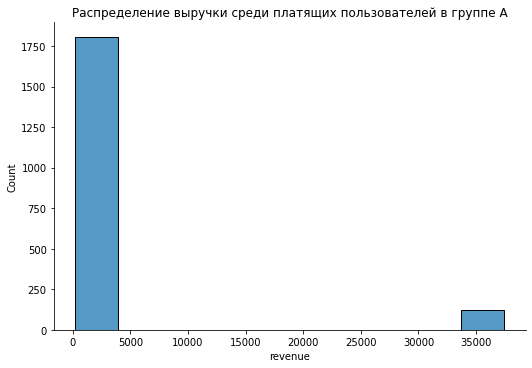

In [19]:
sns.displot(exp_a_payment.revenue, aspect=1.5, bins=10)
plt.title('Распределение выручки среди платящих пользователей в группе A')

Text(0.5, 1.0, 'Распределение выручки среди платящих пользователей в группе B')

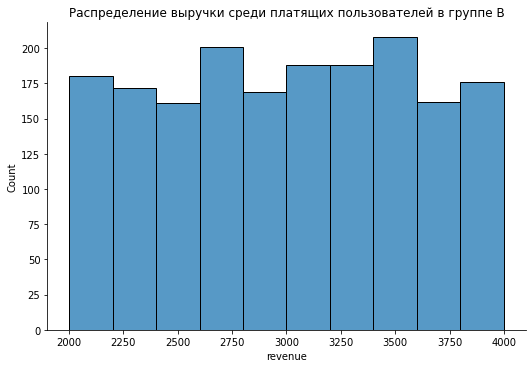

In [20]:
sns.displot(exp_b_payment.revenue, aspect=1.5, bins=10)
plt.title('Распределение выручки среди платящих пользователей в группе B')

### Выводы
- Группа А: распределение визуально отличается от нормального, присутствуют заметные выбросы.
- Группа В: распределение равномерно, заметные выбросы не наблюдаются.

Неясна природа выбросов в группе А. Посмотрим на распределение выручки, убрав данные выбросы.

Text(0.5, 1.0, 'Распределение выручки среди платящих пользователей в группе A (без выбросов)')

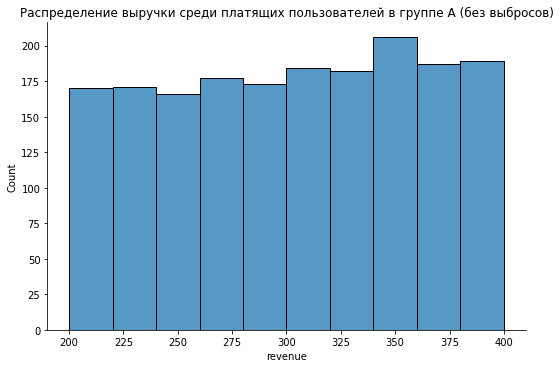

In [21]:
sns.displot(exp_a_payment[exp_a_payment['revenue'] < 30000]['revenue'], aspect=1.5, bins=10)
plt.title('Распределение выручки среди платящих пользователей в группе A (без выбросов)')

Исключив выбросы заметно, что выручка в группе А также распределена равномерно.

Посмотрим на медианную выручку в группе А с выбросами и без выбросов

In [22]:
exp_a_payment.revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [23]:
exp_a_payment[exp_a_payment['revenue'] < 30000]['revenue'].describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

In [24]:
exp_b_payment.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

### Выводы:
Поведение пользователей двух групп кардинально различается. В группе А присутствуют заметные выбросы, а платежи в группе В распределены равномерно.

Для эксперимента важно понимать что из себя представляют "high-price" клиенты в группе А. Можно ли называть их выбросами? Являются ли данные ошибки проблемой системы сплитования или это ошибки записи транзакций?

В группе В выбросов нет, поэтому значения **ARPPU** и **MedianRPPU** вполне согласуются друг с другом (3003.66 и 3022), в то время как в группе А **ARPPU** с выбросами равен 2664.0, а **MedianRPPU** равен 311. Если убрать выбросы из группы А, то значения кардинально изменятся, **ARPPU** станет равен 302.45, а **MedianRPPU** не изменится сильно и будет равен 305.

### Посмотрим на CR в покупку в группах А и В

In [25]:
# Расчитаем CR в покупку для обеих групп, посмотрим на разницу
cr_a = round(exp_a_payment.revenue.count() / exp_a.revenue.count() * 100, 2)
cr_b = round(exp_b_payment.revenue.count() / exp_b.revenue.count() * 100, 2)
cr_diff = round(cr_a - cr_b, 2)
print(f'CR в покупку для группы А: {cr_a}')
print(f'CR в покупку для группы B: {cr_b}')
print(f'Разница: {cr_diff}%')

CR в покупку для группы А: 0.95
CR в покупку для группы B: 0.89
Разница: 0.06%


Заметно, что в контрольной группе коверсия в покупку выше, чем в тестовой. Проверим статистическую значимость данных различий Z-тестом для пропорций.

In [26]:
# Проведём z-test для пропорций

# В контрольной группе (а) 1928 платящих из 202103.
# В тестовой группе (b) 1805 платящих из 202667.
pay1 = 1928
use1 = 202103
pay2 = 1805
use2 = 202667

# H0 - различий в конверсиях нет
# H1 - различия в конверсиях присутствуют
z, p_value = proportions_ztest([pay1, pay2], [use1, use2])
print(f'p_value = {p_value:.3}')

p_value = 0.035


Результат стастически значим, нулевая гипотеза о равенстве пропорций отвергается. Значит, количество платящих пользователей статистически значимо уменьшилось. Это для нас нехорошо. А если исключить из контрольной группы возможные выбросы?

In [27]:
# Посчитаем количество покупателей в контрольной группе без выбросов
pay3 = exp_a_payment[exp_a_payment['revenue'] < 30000].shape[0]

# H0 - различий в конверсиях нет
# H1 - различия в конверсиях присутствуют
z, p_value = proportions_ztest([pay3, pay2], [use1, use2])
print(f'p_value = {p_value:.3}')

p_value = 0.933


В таком случае нулевая гипотеза не отвергается. Но просто так исключить выбросы мы не можем, так как достоверно не знаем их природы. В связи с данным условием для проверки различий между ARPPU в группах необходимо использовать устойчивый к выбросам критерий.

### mannwhitneyu

In [28]:
# Проверка на нормальность распределения в группе А
pg.normality(data=exp_a_payment.revenue)

,W,pval,normal
revenue,0.266792,0.0,False


In [29]:
# Проверка на нормальность распределения в группе В
pg.normality(data=exp_b_payment.revenue)

,W,pval,normal
revenue,0.958312,2.491346e-22,False


Распределения в группах статистически значимо отличаются от нормального.

In [30]:
# Применение критерия Манна-Уитни для сравнения ARPPU
mannwhitneyu(exp_a_payment.revenue, exp_b_payment.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

По результату теста Манна-Уитни p-value < 0.05. Можно утверждать, что разница в ARPPU между тестовой и контрольной группами статистически значима. Однако проблема данного теста состоит в том, что если мы видим статистически значимую разницу между значениями, мы не можем сказать, в чью они пользу, так как критерий Манна-Уитни сравнивает среднией ранги двух групп. Поэтому перейдем к методу bootstrap'а.

### bootstrap
Для реализации проверки гипотез через bootstrap напишем функцию, которая будет реализовывать данный метод и сравним медианные значения MedianRPPU в двух группах, так как для медианы не применима ЦПТ.

In [31]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

Для начала сравним **ARPU** двух групп с помощью bootstrap.

- Н0 - различия между **ARPU** отсутствуют
- Н1 - **ARPU** в группах различны

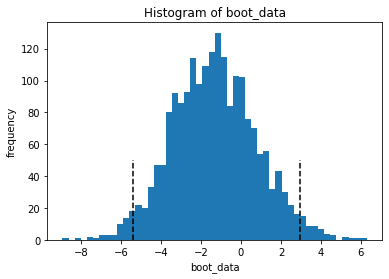

In [32]:
# bootstrap для сравнения ARPU двух групп
# в результате хранится разница двух распределений, ДИ и pvalue
booted_arpu_mean = get_bootstrap(exp_a.revenue, 
                                 exp_b.revenue, 
                                 statistic = np.mean,
                                 boot_it = 2000)

In [33]:
booted_arpu_mean["p_value"]

0.5283468009675983

Ноль попал в доверительный интервал, а p-val > 0.5, что не позволяет нам отвергнуть нулевую гипотезу о равенстве ARPU.

Cравним **ARPPU** двух групп с помощью bootstrap.

- Н0 - различия между **ARPPU** отсутствуют
- Н1 - **ARPPU** в группах различны

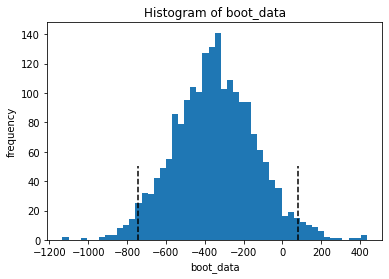

In [34]:
# bootstrap для сравнения ARPPU двух групп
# в результате хранится разница двух распределений, ДИ и pvalue
booted_arppu_mean = get_bootstrap(exp_a_payment.revenue, 
                                  exp_b_payment.revenue, 
                                  statistic = np.mean,
                                  boot_it = 2000)

In [35]:
booted_arppu_mean["p_value"]

0.0968367756875237

Ноль попал в доверительный интервал, а p-val > 0.5, что не позволяет нам отвергнуть нулевую гипотезу о равенстве ARPPU.

Cравним **MedianRPPU** двух групп с помощью bootstrap.

- Н0 - различия между **MedianRPPU** отсутствуют
- Н1 - **MedianRPPU** в группах различны

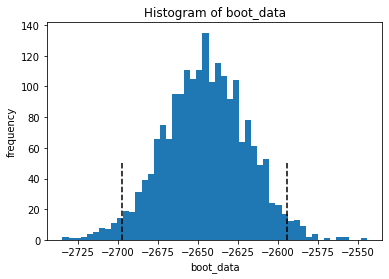

In [36]:
# bootstrap для сравнения MedianRPPU двух групп
# в результате хранится разница двух распределений, ДИ и pvalue
booted_arppu_median = get_bootstrap(exp_a_payment.revenue, 
                                    exp_b_payment.revenue, 
                                    statistic = np.median,
                                    boot_it = 2000)

In [37]:
booted_arppu_median["p_value"]

0.0

Bootstrap для разницы медиан показал наличие стат значимых различий, что логично, так как медиане, в широком смысле, все равно на выбросы. Данный метод, на мой взгляд наиболее точно подходит к даннным с выбросами, так как он исключает трудности интерпретации теста Манна-Уитни, но за эту опцию исследователь платит сложностью (и возможно дороговизной) реализации.

### Общие выводы по задаче 2
Трудно сделать однозначные выводы, потому что контрольная группа имеет большие выбросы , которые сильно влияют на среднее значение дохода с игрока и платящего игрока.
Соответственно, мы получаем противоположные результаты в зависимости от того, включаем ли выбросы в контрольную группу или нет. 

Для окончательного вывода нужно изучить природу выбросов в группе А , выяснить их источник, проверить систему сплитования. Возможно рационально взять дополнительные маркетинговые данные, например, о расходах на данное акционое событие, чтобы посчитать **ROMI** и делать выводы на его базе.

Тестовая группа имеет меньший коэффициент конверсии в покупку, чем контрольная группа. Разница в конверсии статистически значима, если учитывать всех игроков, но при исключении выбросов статзначимость исчезает.

**ARPU**, **ARPPU** в тестовой группе больше, чем в контрольной.
Если не исключать выбросы, применяя бутстрап, мы не можем отклонить нулевую гипотезу о равенстве средних и не можем сделать вывод, что **ARPU** и **ARPPU** тестовой группы статистически значимо больше, чем **ARPU** и **ARPPU** контрольной группы. Однако, используюя бутстрап с медианой, соответственно высчитывая **MedianRPPU**, то разница между группами будет статистически значима и показатели тестовой группы будут выше.

Если окажется, что выбросы вызваны какой-то ошибкой, то мы можем внедрять набор предложений тестовой группы. В противном случае, если выбросы - это реальные "high-price" клиенты, то на них изменения пока не распространяем (по ним лучше отдельно провести А/В-тест и посмотреть, нравится им или нет).

# Задача 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. Ответить на вопрос:
- C помощью каких метрик можно оценить результаты последнего прошедшего события?

### Решение
Перед построением системы метрик необходимо сформулировать пул задач, которые решает данное мероприятие в продукте:
Цели проведения тематических событий в игре:
- Привлечение новой аудитории в игру;
- Удержание существующих пользователей в проекте;
- Возврат ушедших пользователей из проекта;
- Увеличение среднего времени использования приложения;
- Если игра распространяется по модели free to play, то увеличение ARPU и ARPPU.

Метрики для оценки результатов последнего прошедшего события:
1.	**DAU**
2.	**WAU**

Метрики аудитории позволят оценить интерес к событию как на начало, так и на конец его проведения

3.	**Retention n-го дня** (для пользователей, принявших участие в предпоследнем событии в n-ный день последнего события) – позволит увидеть насколько хорошо проводимые события влияют на удержание аудитории;
4.	**CR в прохождение n-ного уровня** – воронка прохождения уровней позволит проследить насколько успешно пользователи проходят тот или иной уровень, поможет выявить проблемы в сложности уровней;
5.	Если игра распространяется по модели free to play, то рационально отслеживать **ARPU и ARPPU**, так как основной доход игра будет приносить с внутренней рекламы или микротранзакций;
6.	Также, free to play модель зачастую предполагает наличие season pass для тематических событий, который позволяет получать различные награды. Может быть интересна метрика **CR в покупку season pass**;
7.	**Среднее время игровой сессии**, **среднее время прохождения тематического события в сессии**, **доля времени прохождения события во всем внутриигровом времени пользователя за период**. Среднее позволит в дальнейшем проводить статистические тесты с помощью параметрических или непараметрических статистических критериев;
8.	**Доля вернувшихся в проект пользователей**. Например, статус покинувшего игру пользователь может получить, если полностью пропустил 2 тематических события. Вернувшимся его можно считать, если он прошел n уровней в текущем тематическом событии.


Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Ответить на вопросы:
- Изменится ли набор метрик оценки результата?
- Если да, то как?

Изменится. К вышеописанному набору метрик добавиться **churn rate**.